GeekBrains, факультет Искусственного интелекта <br>
курс "Фреймворк PyTorch для разработки искусственных нейронных сетей" (17 мая 2023 - 15 июня 2023)

### Урок 8. Generative Adversarial Networks

__Домашнее задание__

Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики



Подключаем нужные модули и библиотеки

In [1]:
# import os
import numpy as np
import math
import torch
import torch.nn as nn
# import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from IPython import display
from torchvision.utils import save_image, make_grid

Определим нужное нам устройство:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Dataset

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        # return torch.FloatTensor([point, self.func(point)])
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

### Function

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10

In [5]:
MIN = -15
MAX = 15
NUM = 10000

In [6]:
data = Data(FUNC, MIN, MAX, NUM)
data[0]

tensor([-2.6477,  0.4438])

## 2. DataLoader

In [7]:
data_loader = DataLoader(data, batch_size = 1000, shuffle=True)

## 3. Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

## 4. Discriminator

In [9]:
class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(2, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
    self.linear_3 = nn.Linear(hidden_dim // 2, 1)

  def forward(self, x): 
    
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.sigmoid(x)
    return x

## 5. Training

### Initialization

In [10]:
n_epochs = 1000  # количество эпох
lr = 0.01  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 1  # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64

In [11]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [12]:
d_loss_history = []
g_loss_history = []

### Learning process

Epoch: 10; Discriminator_loss: 0.691; Generator_loss: 0.706


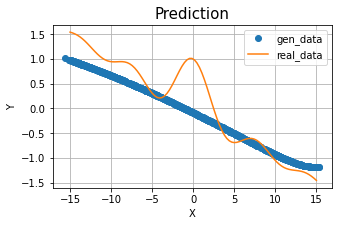

Epoch: 20; Discriminator_loss: 0.684; Generator_loss: 0.739


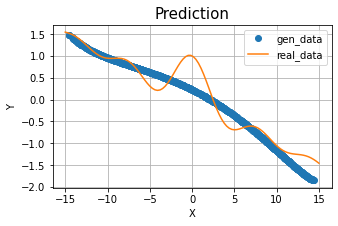

Epoch: 30; Discriminator_loss: 0.659; Generator_loss: 0.81


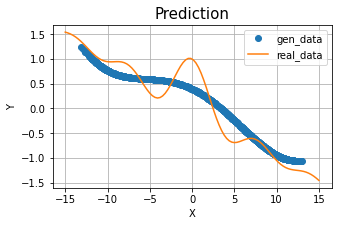

Epoch: 40; Discriminator_loss: 0.64; Generator_loss: 0.855


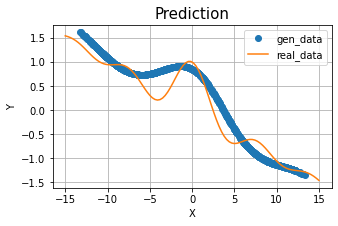

Epoch: 50; Discriminator_loss: 0.687; Generator_loss: 0.769


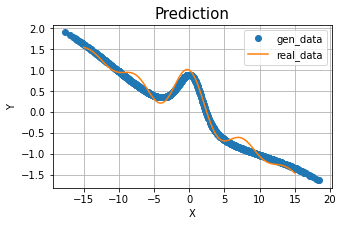

Epoch: 60; Discriminator_loss: 0.668; Generator_loss: 0.837


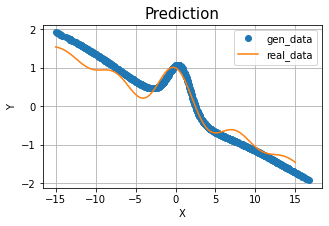

Epoch: 70; Discriminator_loss: 0.673; Generator_loss: 0.759


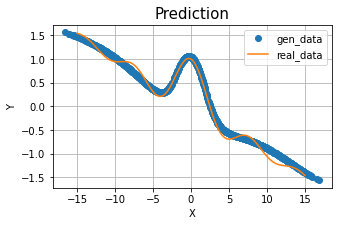

Epoch: 80; Discriminator_loss: 0.673; Generator_loss: 0.75


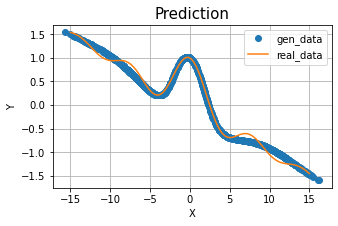

Epoch: 90; Discriminator_loss: 0.682; Generator_loss: 0.73


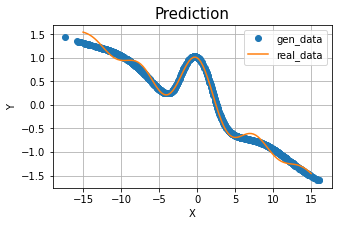

Epoch: 100; Discriminator_loss: 0.682; Generator_loss: 0.714


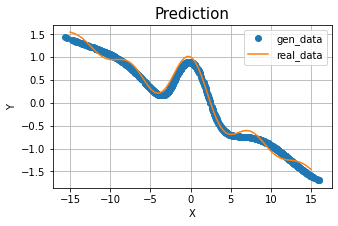

Epoch: 200; Discriminator_loss: 0.684; Generator_loss: 0.728


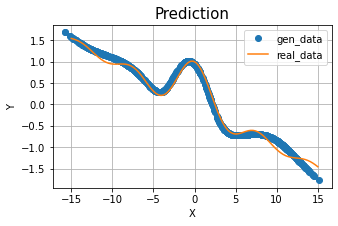

Epoch: 300; Discriminator_loss: 0.648; Generator_loss: 0.888


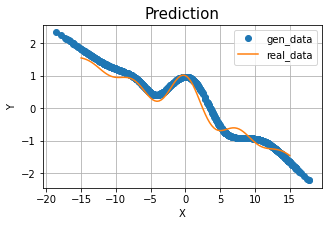

Epoch: 400; Discriminator_loss: 0.671; Generator_loss: 0.873


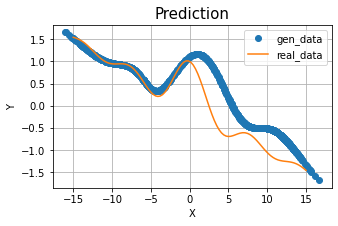

Epoch: 500; Discriminator_loss: 0.663; Generator_loss: 0.819


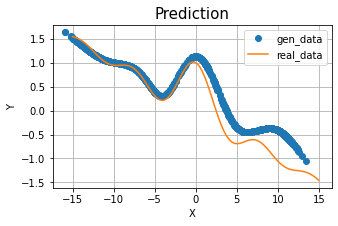

Epoch: 600; Discriminator_loss: 0.656; Generator_loss: 0.846


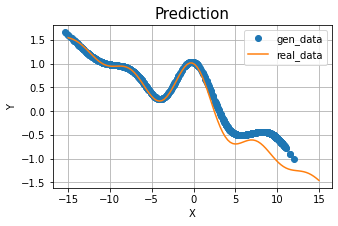

Epoch: 700; Discriminator_loss: 0.674; Generator_loss: 0.887


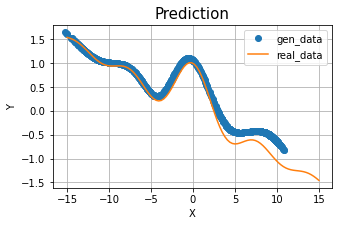

Epoch: 800; Discriminator_loss: 0.645; Generator_loss: 0.988


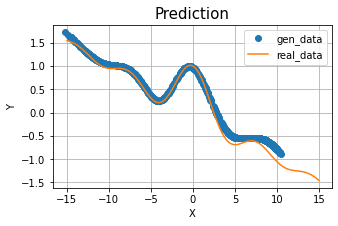

Epoch: 900; Discriminator_loss: 0.655; Generator_loss: 0.937


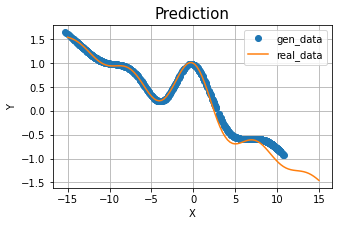

Epoch: 1000; Discriminator_loss: 0.628; Generator_loss: 1.038


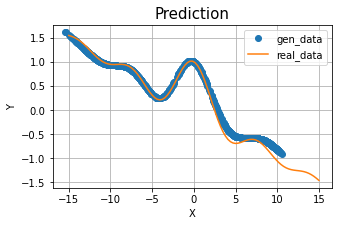

In [13]:
for epoch in range(n_epochs):    

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума        
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
        
######## Отображение процесса обучения и вывод функций потерь ############
    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
    
        plt.figure(figsize = (5,3))
        plt.title('Prediction', fontsize = 15)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 10)
        plt.xlabel('X', fontsize = 10)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 10)
        plt.show()
    
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

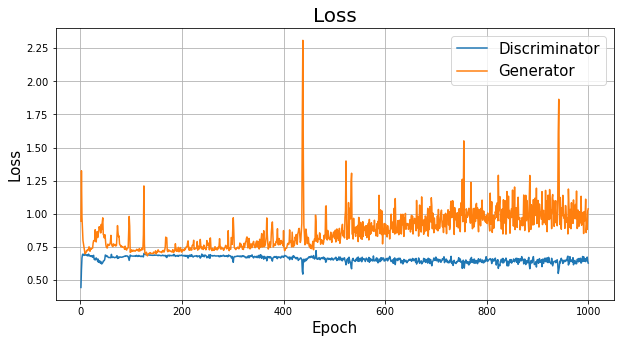

In [14]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);

## Вывод

Я сгенерировал синтетические данные, как точки (x,y)

Я построил простейший Discriminator, 3 слойная линейная нейронная сеть с функциями активации relu и выходной функцией sigmoid, чтобы получить вероятностную оценку от 0 до 1 для точек.

Я построил Generator, 2 слойная линейная нейронная сеть с функцией активации tanh, так как эта функция хорошо описывает sin(x) который присутствует в реальных данных, но tanh хуже чем relu передаёт градиент, поэтому в нейронной сети всего 2 слоя. На выходе не стоит функция активации, так как в теории точка (x,y) имеет область определения от -inf до +inf для каждой координаты.

Латентный вектор имеет размероность один, так как чтобы построить точки (x,y), где y=f(x), достаточно знать только x, а значит можно взять размерность один для латентного вектора z, ведь наш генератор может отобразить эту координату из латентного пространства на ось Х, а дальше найти y=f(x), только делая это параллельно, а не последовательно. Таким образом теоретически понятно, что для латентного вектора достаточно размерности один. Так же можно заметить, что при такой размерности латентного вектора распределение точек сразу принимает форму какой-то кривой, а не области, что уже является правильным, а значит брать большую размерность для латентного вектора неэффективно.

Как можно увидеть на графиках, на первых 100 эпохах идёт активное обучение генератора, дальше можно заметить, что генератору не удаётся построить только краевые точки. Это связано с тем, что при обучении генератора мы подаём ему на вход нормальное распределение, а значит генератор гораздо чаще строит точки в середине и гораздо реже краевые точки, соответственно реже на них ошибается и реже настраивает для них веса, зато он почти не ошибается для точек в центре.

В целом можно сказать, что у нас получилось научить генератор создавать точки из заданной функции. 